In [1]:
from iqm.benchmarks.compressive_gst.compressive_gst import GSTConfiguration
from iqm.benchmarks.benchmark_experiment import BenchmarkExperiment

import json
import matplotlib.pyplot as plt
import pickle

## Choose (or define) a backend

In [2]:
#backend = "IQMFakeAdonis"
backend = "IQMFakeApollo"
#backend = "garnet"

### Minimal GST Experiment configurations

The most important parameters are the following:
- qubits (`List[int]`): The qubits on the backend where the experiment is performed.
- gate_set (`Union[str, List[Type[QuantumCircuit]]]`): Either one of the currently predefined gate sets `"1QXYI"`, `"2QXYCZ"`, `"2QXYCZ_extended"`, `"3QXYCZ"`, or a list of quantum circuits.
- num_circuits (`int`): The number of circuits for the experiment. Recommended are at least 50 for single qubit GST, at least 300 for two-qubit GST and at least 2000 for 3-qubit GST. 
- shots (`int`): The number of shots per circuit.
- rank (`int`): The Kraus rank of the reconstruction, i.e. the number of Kraus operators for each gate.
      $$ G(\rho) = \sum_{i = 1}^{\text{rank}} K_i \rho K_i^{\dagger}$$
  Setting `rank=1` will trigger a unitary gate fit, leading to a gate parametrization output in terms Hamiltonian parameters.
  The maximum rank is given by the physical dimension squared. For fully rigorous performance computation of metrics such as the average gate fidelity or the diamond distance it is recommended to choose full rank.
  A low rank has the benefit of needing less circuits and less computing time, while still capturing the dominant error sources.
- bootstrap_samples (`int`): If bootstrapping error bars are to be generated, this variable sets the number of bootstrap runs. Recommended for trustworthy error bars are 50 samples. The default is 0, since computing bootstrap error bars is very time consuming. 

In [3]:
Minimal_1Q_GST = GSTConfiguration(
    qubits=[0],
    gate_set="1QXYI",
    num_circuits=50,
    shots=1000,
    rank=4,
    bootstrap_samples=0,
)

Minimal_2Q_GST = GSTConfiguration(
    qubits=[0,1],
    gate_set="2QXYCZ",
    num_circuits=300,
    shots=1000,
    rank=2,
    bootstrap_samples=0,
)

## Execute GST Experiment(s)

In [4]:
EXAMPLE_GST = BenchmarkExperiment(backend, [Minimal_1Q_GST])
EXAMPLE_GST.run_experiment()


Now executing compressive_GST
Now generating 50 random circuits on qubits [0]
Will transpile all 50 circuits according to fixed physical layout
Transpiling for backend IQMFakeApolloBackend with optimization level 0, sabre routing method all circuits
	"perform_backend_transpilation" took 4.78 sec
	"generate_meas_circuits" took 6.20 sec
Now executing the corresponding circuit batch
Submitting batch with 50 circuits corresponding to qubits [0]
	"submit_execute" took 0.00 min
Retrieving all counts
	"retrieve_all_counts" took 1.56 sec
Starting mGST optimization...
 11%|█         | 11/100 [00:27<03:44,  2.52s/it]
	 Convergence criterion satisfied
	 Final objective 2.77e-4 in time 27.79s

Results for IQMFakeApolloBackend with qubits [0]
Total GST post-processing time: 0.47 min
Overview results: 
                 F_avg  Min. Spectral distances
Idle:[0]      0.990017                 0.016132
Rx(pi/2):[0]  0.995465                 0.006855
Ry(pi/2):[0]  0.993059                 0.011734
  Final

C:\Users\RaphaelBrieger\miniconda3\envs\qcvv-suite\Lib\site-packages\pydantic\main.py:390: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue: Expected `str` but got `list` with value `[4, 0.0001]` - serialized value may not be as expected
  PydanticSerializationUnexpectedValue: Unexpected Value
  return self.__pydantic_serializer__.to_python(


## Examine the results

#### Example

In [5]:
experiment_results = EXAMPLE_GST.benchmarks['compressive_GST'].results
print("Experiment results keys:\n")
for k in experiment_results.keys():
    print(f"{k}")

Experiment results keys:

choi_evals
qubit_set
quick_metrics
full_metrics
main_mGST_time
submit_time
retrieve_time
gauge_optimization_time
circuit_generation_time


#### The error metrics can be accessed as follows

In [6]:
print(json.dumps(experiment_results['full_metrics'], sort_keys=True, indent=4))

{
    "Gates": {
        "Avg. gate fidelity": {
            "0": "0.99681",
            "1": "0.99349",
            "2": "0.99785"
        },
        "Diamond distance": {
            "0": "0.01285",
            "1": "0.01269",
            "2": "0.00562"
        },
        "Unitarity": {
            "0": "0.98765",
            "1": "0.97441",
            "2": "0.99156"
        }
    },
    "Outcomes and SPAM": {
        "Mean TVD: estimate - data": {
            "": "0.00713"
        },
        "Mean TVD: target - data": {
            "": "0.03366"
        },
        "POVM - diamond dist.": {
            "": "0.00565"
        },
        "State - trace dist.": {
            "": "0.04164"
        }
    }
}


#### Accessing the final gate set estimates for further processing
Two gate sets are saved, the raw gate set and the gauge-optimized gate set. 
In most instances the gauge-optimized gate set should be used for further processing, since it gives the gate set in the same basis (loosely speaking) in which the target gates are defined. 

The `"raw_gates"` and `"gauge_opt_gates"` keys in the outcome dictionary contain a 3D numpy array, where i.e. gate #1 is accessed with `raw_results["gauge_opt_state"][0]`, and so on.

In [7]:
results_dir = f"Outputs/{EXAMPLE_GST.device_id}/{EXAMPLE_GST.timestamp}/compressive_GST/"
filename = f"{results_dir}{EXAMPLE_GST.device_id}_{EXAMPLE_GST.timestamp}_compressive_GST_raw_results.pkl"
with open(filename, "rb") as f_raw_results:
    raw_results = pickle.load(f_raw_results)
print(raw_results.keys())
print(raw_results["gauge_opt_state"])

dict_keys(['raw_Kraus_operators', 'raw_gates', 'raw_POVM', 'raw_state', 'gauge_opt_gates', 'gauge_opt_POVM', 'gauge_opt_state', 'mGST_circuits', 'mGST_outcome_probs'])
[[ 0.96112929+0.j         -0.01455246+0.00330189j]
 [-0.01455246-0.00330189j  0.03887071+0.j        ]]


### Plots
The plots can either be accessed as png files in the Outputs-fodler, or displayed again in the notebook as follows.

process_mat_plot_0, Figure(606.061x195.122)
process_mat_plot_1, Figure(606.061x195.122)
process_mat_plot_2, Figure(606.061x195.122)
SPAM_matrices_real, Figure(640x480)
SPAM_matrices_imag, Figure(640x480)


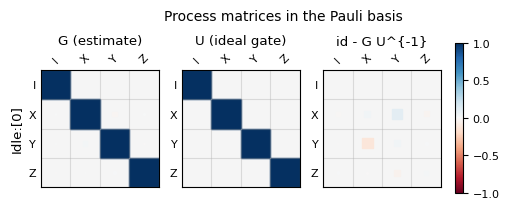

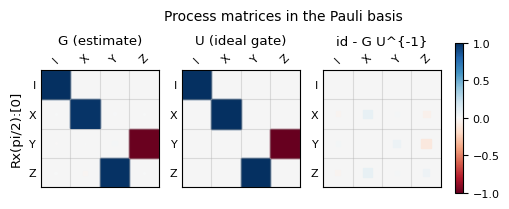

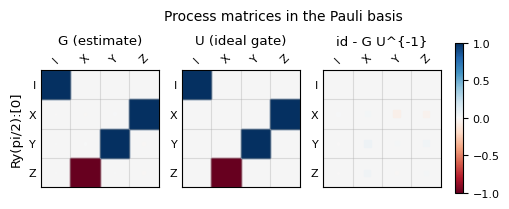

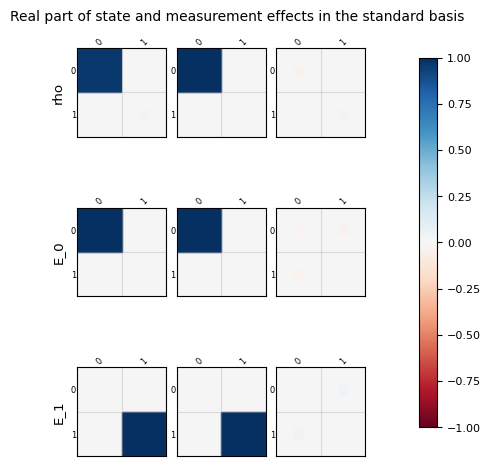

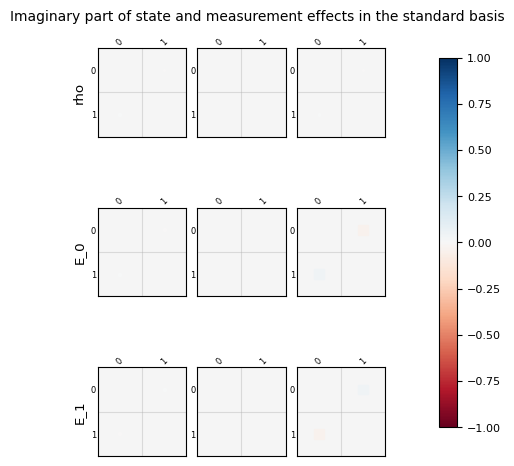

In [9]:
experiment_figures = EXAMPLE_GST.benchmarks['compressive_GST'].figures
for k, v in experiment_figures.items():
    print(f"{k}, {v}")
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = v
    v.set_canvas(new_manager.canvas)